<a href="https://colab.research.google.com/github/RidmieWee/DS_Project/blob/main/3.%20Implementation/gaze_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import random
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.utils import to_categorical
from google.colab import drive

In [2]:
# Mount into the drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploratary Data Analysis

In [3]:
# Define data folder and classes
images = '../content/drive/MyDrive/Research/data_gaze'
categories = ['look_forward', 'look_left', 'look_right']

In [4]:
# Define a array for stre images
data = []

# Define a function to extract data from folder
def extract_data():
    # Iterate over each folder in directory
    for category in categories:
        # Defie the path to directory
        path = os.path.join(images, category)
        # Extract the index
        class_num = categories.index(category)
        # Iterate over each imane
        for img in os.listdir(path):
            try:
                # Read image
                img_array = cv2.imread(os.path.join(path, img))
                # Add image and labelinto new array
                data.append([img_array, category])
            # Check for any errors to ignore
            except Exception as e:
                pass

In [5]:
# Call function to extract data
extract_data()

In [6]:
# Ensure the data length
print(len(data))

10121


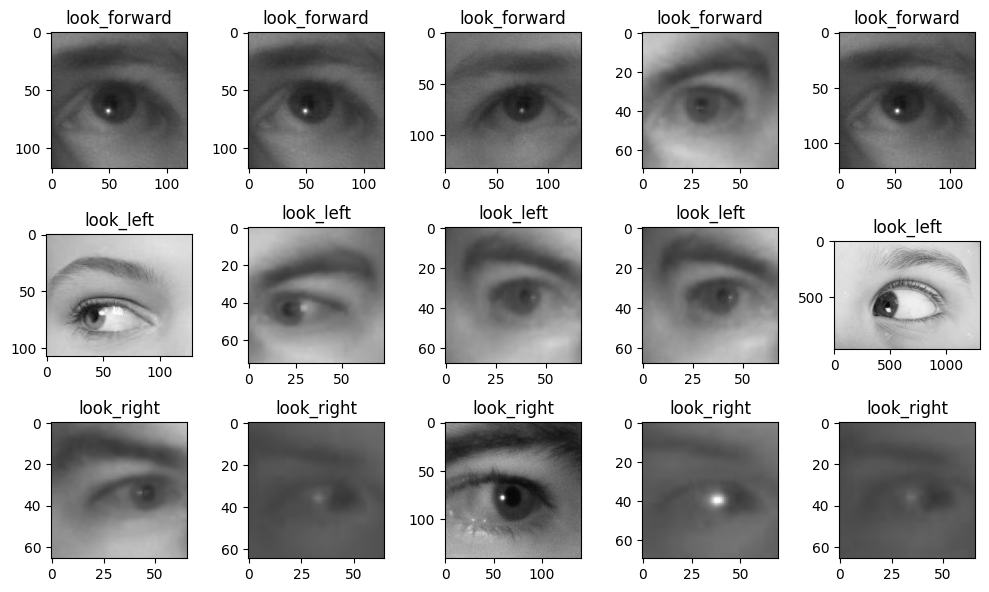

In [7]:
# Explore extract images

# Define the number of rows and columns
rows = 3
columns = 5

# Define size for the figure
plt.figure(figsize=(10, 6))

# Iterate over each class
for class_name in categories:
    # Filter images of each class
    class_images = [img_data for img_data in data if img_data[1] == class_name]
    # Plot images of each class
    for i in range(min(len(class_images), 5)):
        plt.subplot(rows, columns, categories.index(class_name) * 5 + i + 1)
        plt.imshow(class_images[i][0])
        plt.title(class_name)
        plt.axis('on')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
# Calculate image statistics

# Define a function to extract image statistics
def calculate_image_statistics(data):
    # Define dictionary to store statistics for each category
    statistics = {'look_forward': [], 'look_left': [], 'look_right': []}
    # Iterate over each image-category pair
    for image, category in data:
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Add mean pixel intensity
        statistics[category].append(np.mean(grayscale_image))
    # Return new dictionary
    return statistics

# Call function to calculate image statistics
image_statistics = calculate_image_statistics(data)

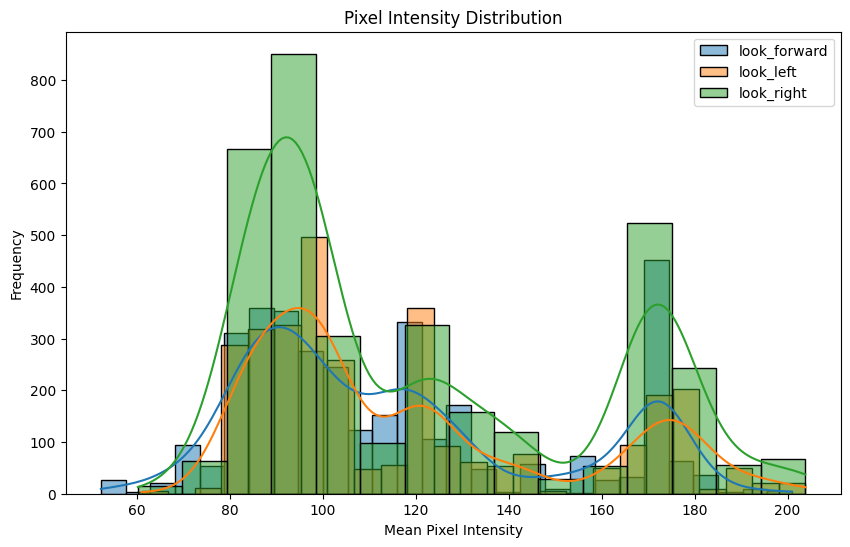

In [9]:
# Plot histograms of pixel intensity distributions
# Define a figure
plt.figure(figsize=(10, 6))

# Iterte over each category
for category in categories:
    # Plot data points as a histogram
    sns.histplot(image_statistics[category], kde=True, label=category, alpha=0.5)

# Define labels for axies and title
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
# Add legend
plt.legend()

# Plot the graph
plt.show()

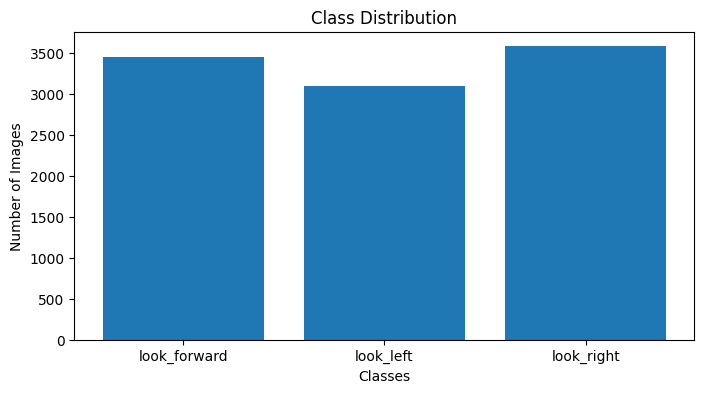

In [10]:
# Identify class imbalance

# Define a figure
plt.figure(figsize=(8, 4))

# Calculate the total images
image_count = {category: len([img for img,
                              cat in data if cat == category])
                              for category in categories}

# Plot the count of each category
plt.bar(image_count.keys(), image_count.values())

# Define axis labels and titles
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')

# Show the plot
plt.show()

In [11]:
# Check the shape of each image

# Iterate over each image
for image, category in data:

    # Check the shape
    image_shape = image.shape

    # Print the shape
    print(f"Image shape: {image_shape}, Category: {category}")

Streaming output truncated to the last 5000 lines.
Image shape: (71, 71, 3), Category: look_left
Image shape: (77, 77, 3), Category: look_left
Image shape: (80, 80, 3), Category: look_left
Image shape: (88, 88, 3), Category: look_left
Image shape: (108, 108, 3), Category: look_left
Image shape: (82, 82, 3), Category: look_left
Image shape: (72, 72, 3), Category: look_left
Image shape: (77, 77, 3), Category: look_left
Image shape: (84, 84, 3), Category: look_left
Image shape: (79, 79, 3), Category: look_left
Image shape: (111, 111, 3), Category: look_left
Image shape: (73, 73, 3), Category: look_left
Image shape: (71, 71, 3), Category: look_left
Image shape: (73, 73, 3), Category: look_left
Image shape: (78, 78, 3), Category: look_left
Image shape: (108, 108, 3), Category: look_left
Image shape: (82, 82, 3), Category: look_left
Image shape: (85, 85, 3), Category: look_left
Image shape: (81, 81, 3), Category: look_left
Image shape: (85, 85, 3), Category: look_left
Image shape: (72, 72, 3

In [12]:
# Define the newsize
new_size = (64, 64)

# Iterate over each image
for i in range(len(data)):

    # Extract image and category
    image, category = data[i]

    # Resize the image
    resized_image = cv2.resize(image, new_size)

    # Add the image with new size
    data[i] = (resized_image, category)

In [13]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64, 3)


In [14]:
# Iterate over each image
for i in range(len(data)):
    # Extract the images and label
    img_array, category = data[i]

    # Convert it into grayscale
    grayscale_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

    # Update the data list with the grayscale image
    data[i] = [grayscale_img, category]


In [15]:
# Extract one image
image1 = data[0][0]

# Check shape of the image
image_shape = image1.shape

# Print the shape
print(image_shape)

(64, 64)


# Data Preprocessing

In [16]:
# Construct random data

# Shuffling the data
random.shuffle(data)

In [17]:
# Define lists data images and labels
X = []
y = []

# Iterate over each image
for features, label in data:

    # Add images into the list
    X.append(features)
    # Add labels into the list
    y.append(label)

# Convert into a numpy array
X = np.array(X)
Y = np.array(y)

In [18]:
# Explore the shape of image list
X.shape

(10121, 64, 64)

In [19]:
# Expanding 2D dimension into 3D
X = np.expand_dims(X,-1)

In [20]:
# Splitting data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [21]:
# Explore shape
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(6781, 64, 64, 1) (6781,) (3340, 64, 64, 1) (3340,)


In [22]:
# Normalizing the images using min-max scaling

# Normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Reduce pixel values
x_train /= 255
x_test /= 255

In [23]:
# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [24]:
# One-hot encode the integer labels
y_train_onehot = to_categorical(y_train_encoded, num_classes=3)
y_test_onehot = to_categorical(y_test_encoded, num_classes=3)

In [25]:
# Explore shape
print(x_train.shape, y_train_onehot.shape, x_test.shape, y_test_onehot.shape)

(6781, 64, 64, 1) (6781, 3) (3340, 64, 64, 1) (3340, 3)


In [26]:
# Define data augmentation
train_generator = ImageDataGenerator(
    # Randomly rotate image
    #rotation_range=20,
    # Defime zoom range
    zoom_range=0.15,
    # Randomly shift images horizontally
    width_shift_range=0.2,
    # Randomly shift images vertically
    height_shift_range=0.2,
    # Define random shear
    shear_range=0.15,
    # Define flip image
    horizontal_flip=True,
    # Define mode for filling points
    fill_mode="nearest")

In [27]:

# Load one image
img = cv2.imread('../content/drive/MyDrive/Research/data_gaze/look_forward/forward_look (8).png', cv2.IMREAD_GRAYSCALE)

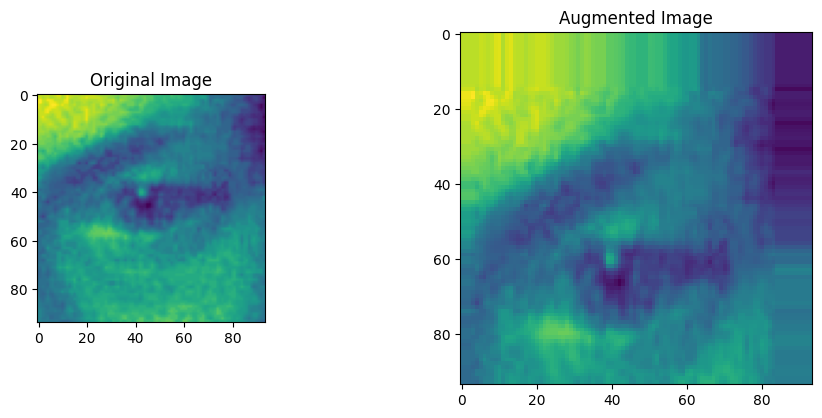

In [28]:
# Display exampleoutput after data augmentation

# Convert sample image tp numpy array
original_img_array = img_to_array(img)

# Apply augmentation to sample image
augmented_img_array = train_generator.random_transform(original_img_array)

# Convert augmented image back to PIL format
augmented_img = array_to_img(augmented_img_array)

# Plot the original and augmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(augmented_img)
plt.title('Augmented Image')

plt.show()


# Model definition, training and evaluation

## 1. ModelA - Model with conv2D(16,32) + Flatten + Dense(32,3)

In [125]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# First convolutional block
conv1 = Conv2D(16, 3, activation='relu')(input_layer)
conv2 = Conv2D(32, 3, activation='relu')(conv1)

# Flatten layer
flatten = Flatten()(conv2)

# Fully connected layers
dense1 = Dense(32, activation='relu')(flatten)
output_layer = Dense(3, activation='softmax')(dense1)

# Create base model
modelA = Model(inputs=input_layer, outputs=output_layer)

In [31]:
modelA.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 32)                3686432   
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 3691331 (14.08 MB)
Trainable params: 3691331 (1

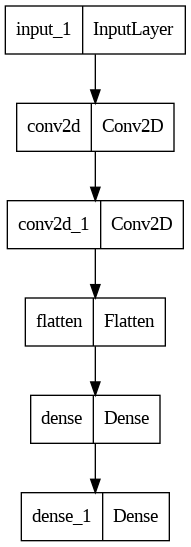

In [32]:
plot_model(modelA)

In [126]:
# Compiling the model
modelA.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Define the path to save the model
path = '../content/drive/MyDrive/Research/Saved_models/Gaze_detection'

# Ensure the directory exists
os.makedirs(path, exist_ok=True)

In [35]:
# Define the path to save the model
model_checkpoint_path_modelA = os.path.join(path, 'bestModel_modelA.h5')

In [36]:
callback_modelA = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelA,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [37]:
# Train the model
history_modelA_1 = modelA.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_modelA)

Epoch 1/30
169/170 [============================>.] - ETA: 0s - loss: 0.7699 - accuracy: 0.7130
Epoch 1: val_loss improved from inf to 0.29993, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA.h5
170/170 [==============================] - 13s 69ms/step - loss: 0.7689 - accuracy: 0.7129 - val_loss: 0.2999 - val_accuracy: 0.8850
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/170 [============================>.] - ETA: 0s - loss: 0.2642 - accuracy: 0.9164
Epoch 2: val_loss improved from 0.29993 to 0.20966, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA.h5
170/170 [==============================] - 11s 68ms/step - loss: 0.2641 - accuracy: 0.9165 - val_loss: 0.2097 - val_accuracy: 0.9337
Epoch 3/30
169/170 [============================>.] - ETA: 0s - loss: 0.2059 - accuracy: 0.9368
Epoch 3: val_loss improved from 0.20966 to 0.19961, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA.h5
170/170 [==============================] - 12s 68ms/step - loss: 0.2053 - accuracy: 0.9369 - val_loss: 0.1996 - val_accuracy: 0.9315
Epoch 4/30
169/170 [============================>.] - ETA: 0s - loss: 0.1665 - accuracy: 0.9491
Epoch 4: val_loss improved from 0.19961 to 0.17827, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA.h5
170/170

In [38]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_1 = history_modelA_1.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_1[0])
print('Test accuracy:', test_loss_accuracy_modelA_1[1])

105/105 [==============================] - 1s 13ms/step - loss: 0.0919 - accuracy: 0.9811
Test loss: 0.09194202721118927
Test accuracy: 0.981137752532959


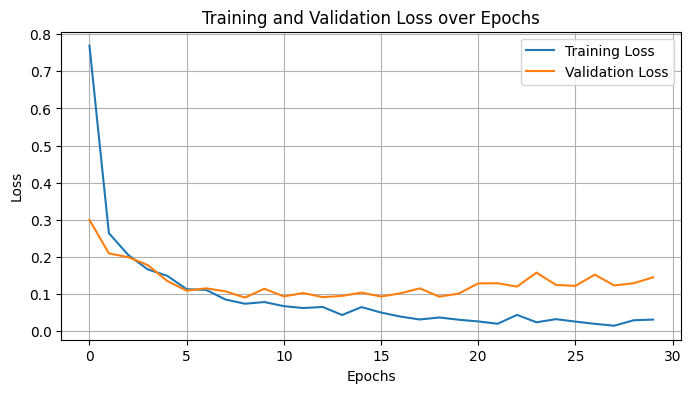

In [39]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_1.history['loss'], label='Training Loss')
plt.plot(history_modelA_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

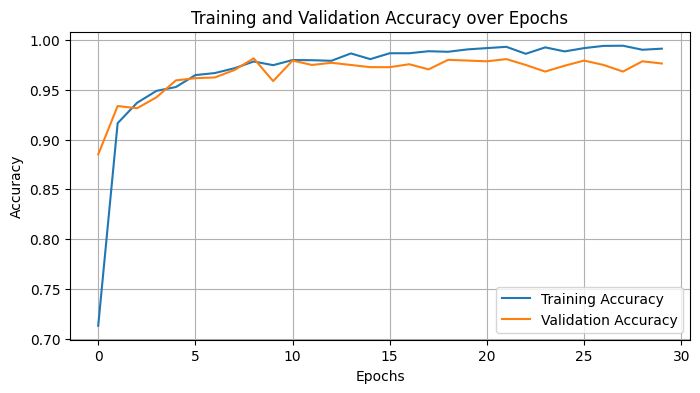

In [40]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [41]:
# Save the entire model
history_modelA_1.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelA_1.h5')

105/105 [==============================] - 2s 14ms/step


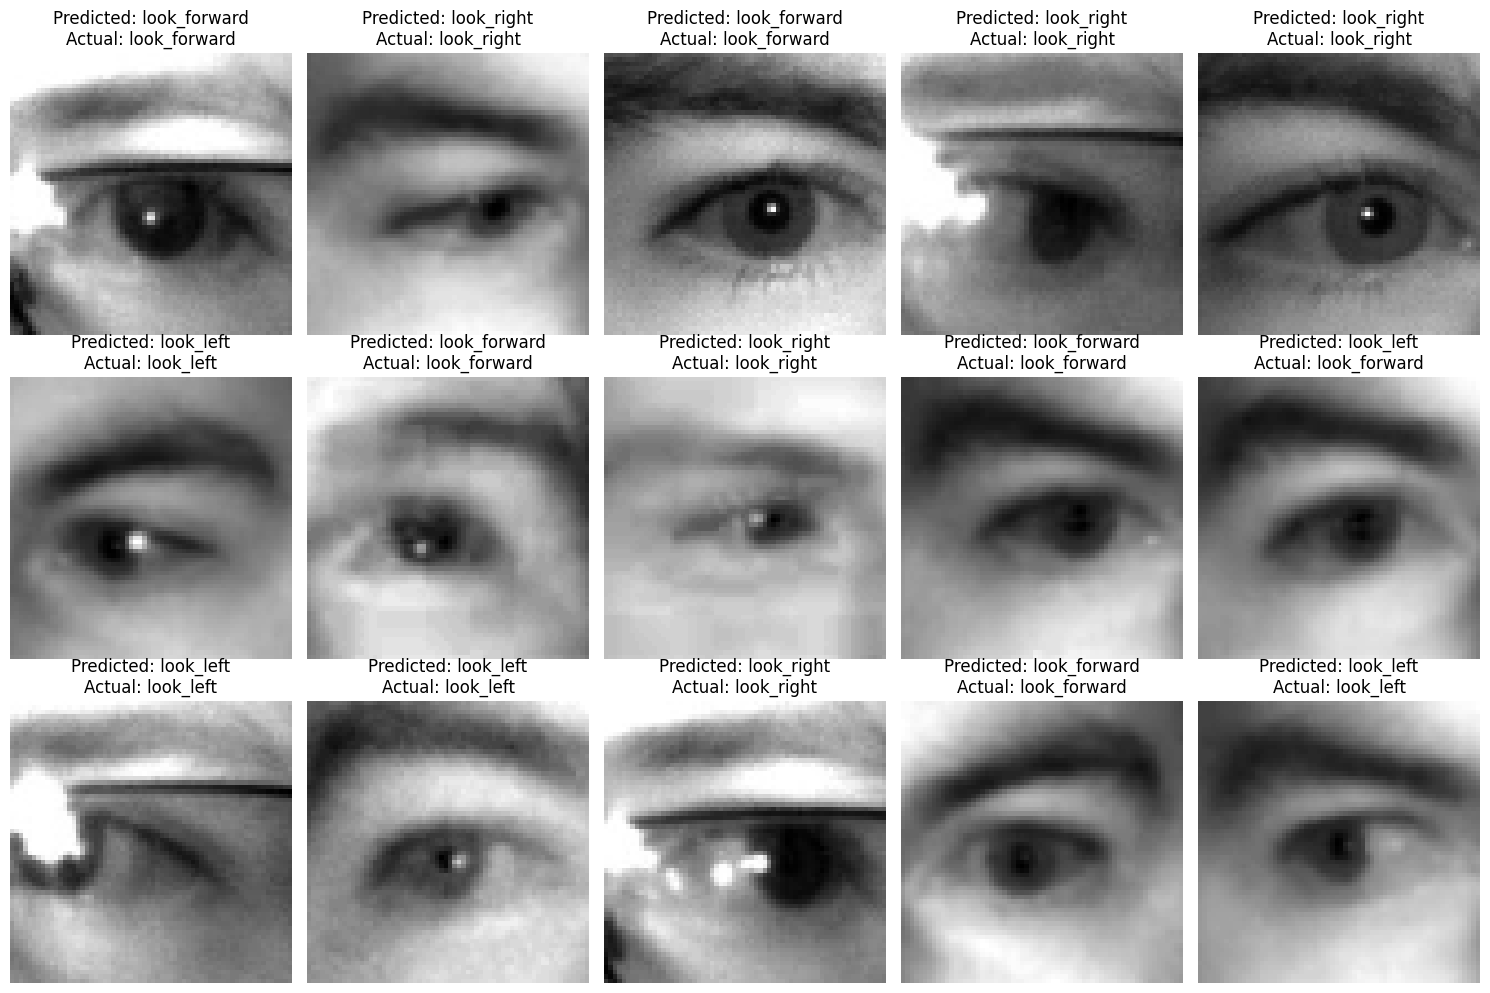

In [42]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelA_1.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 12ms/step


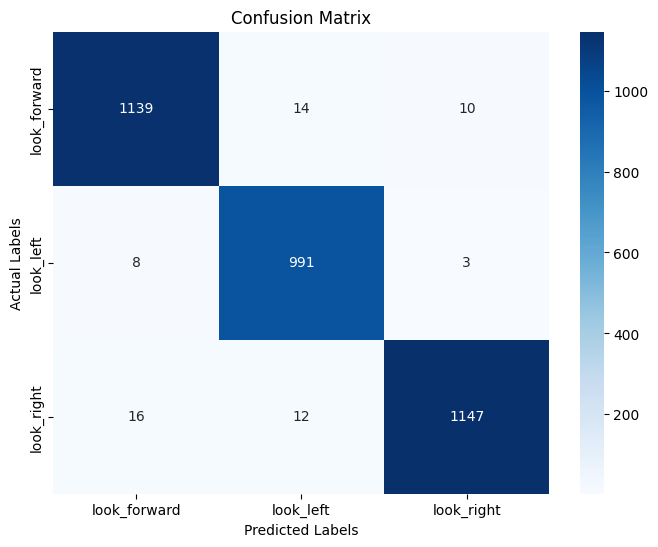

Classification Report:
               precision    recall  f1-score   support

look_forward       0.98      0.98      0.98      1163
   look_left       0.97      0.99      0.98      1002
  look_right       0.99      0.98      0.98      1175

    accuracy                           0.98      3340
   macro avg       0.98      0.98      0.98      3340
weighted avg       0.98      0.98      0.98      3340



In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(history_modelA_1.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

## 2. ModelB - Previous model with maxpooling layers

In [44]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# First convolutional block
conv1 = Conv2D(16, 3, activation='relu')(input_layer)
max_pool1 = MaxPooling2D(3)(conv1)

conv2 = Conv2D(32, 3, activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(3)(conv2)

# Flatten layer
flatten = Flatten()(max_pool2)

# Fully connected layers
dense1 = Dense(32, activation='relu')(flatten)
output_layer = Dense(3, activation='softmax')(dense1)

# Create base model
modelB = Model(inputs=input_layer, outputs=output_layer)

In [45]:
modelB.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0   

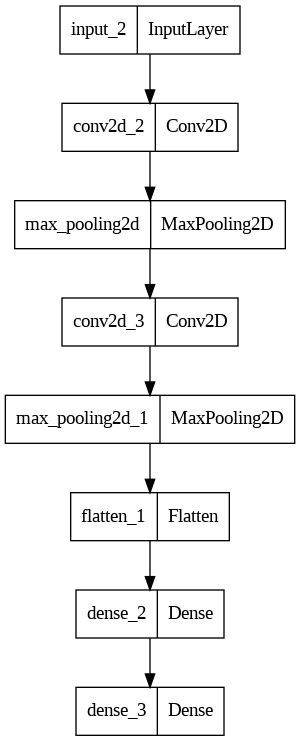

In [46]:
plot_model(modelB)

In [47]:
# Compiling the model
modelB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Define the path to save the model
model_checkpoint_path_modelB = os.path.join(path, 'bestModel_modelB.h5')

In [49]:
callback_modelBB = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelB,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [50]:
# Train the model
history_modelB_1 = modelB.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_modelBB)

Epoch 1/30
168/170 [============================>.] - ETA: 0s - loss: 0.7884 - accuracy: 0.6404
Epoch 1: val_loss improved from inf to 0.43283, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelB.h5
170/170 [==============================] - 4s 19ms/step - loss: 0.7849 - accuracy: 0.6421 - val_loss: 0.4328 - val_accuracy: 0.8217
Epoch 2/30
  9/170 [>.............................] - ETA: 2s - loss: 0.4087 - accuracy: 0.8681

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/170 [============================>.] - ETA: 0s - loss: 0.3670 - accuracy: 0.8746
Epoch 2: val_loss improved from 0.43283 to 0.30792, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelB.h5
170/170 [==============================] - 3s 18ms/step - loss: 0.3657 - accuracy: 0.8752 - val_loss: 0.3079 - val_accuracy: 0.9020
Epoch 3/30
169/170 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.9120
Epoch 3: val_loss improved from 0.30792 to 0.28802, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelB.h5
170/170 [==============================] - 3s 19ms/step - loss: 0.2776 - accuracy: 0.9119 - val_loss: 0.2880 - val_accuracy: 0.8836
Epoch 4/30
167/170 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9281
Epoch 4: val_loss improved from 0.28802 to 0.21309, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelB.h5
170/170 [

In [51]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelB_1 = history_modelB_1.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelB_1[0])
print('Test accuracy:', test_loss_accuracy_modelB_1[1])

105/105 [==============================] - 1s 6ms/step - loss: 0.0640 - accuracy: 0.9832
Test loss: 0.06404364854097366
Test accuracy: 0.9832335114479065


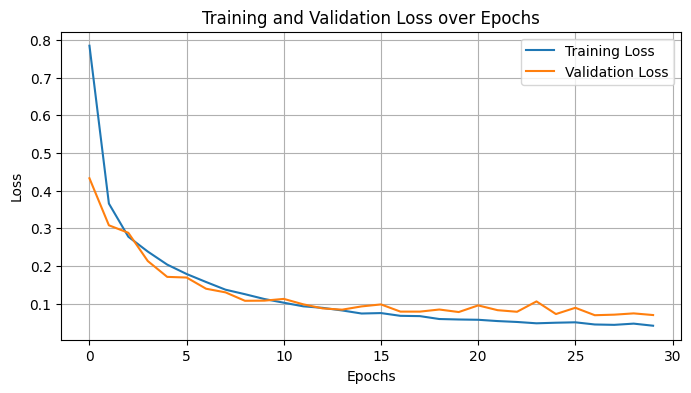

In [52]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelB_1.history['loss'], label='Training Loss')
plt.plot(history_modelB_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

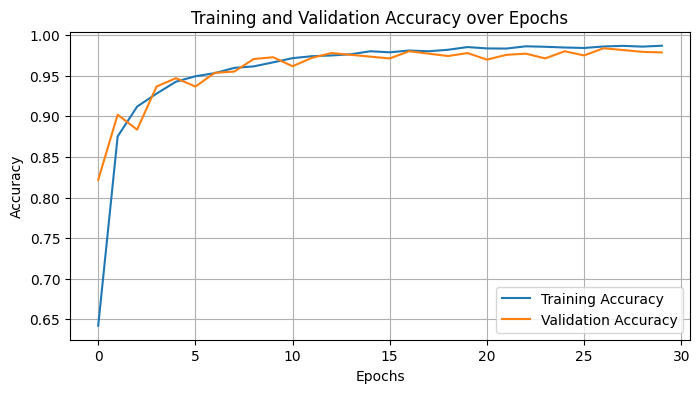

In [53]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelB_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelB_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [54]:
# Save the entire model
history_modelB_1.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelB_1.h5')

105/105 [==============================] - 1s 6ms/step


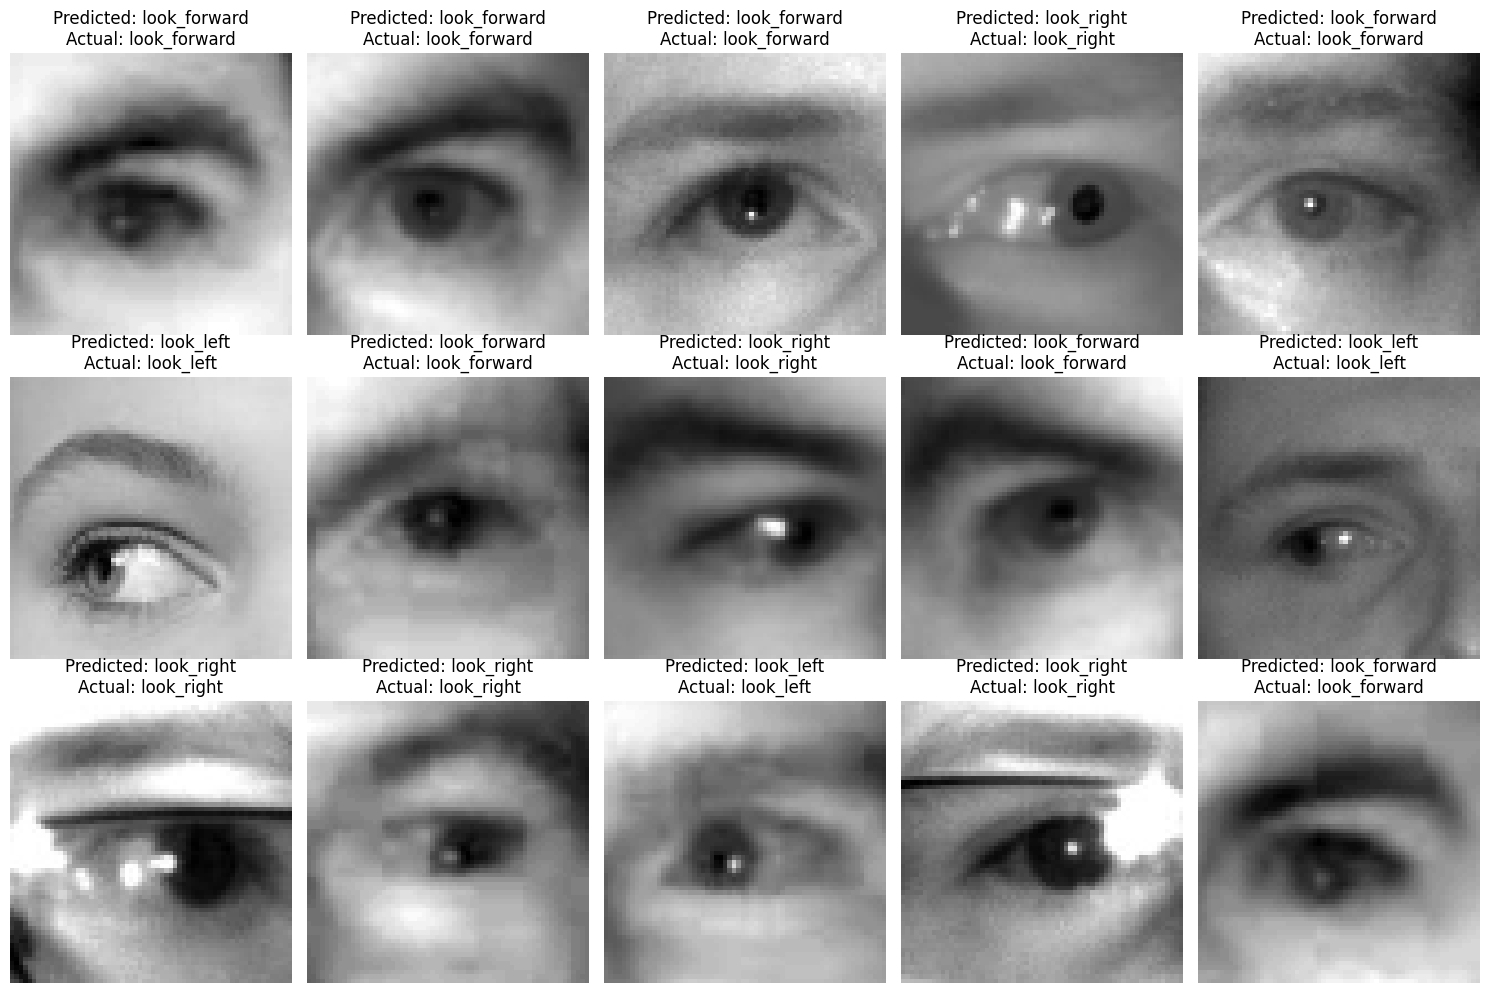

In [55]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelB_1.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 6ms/step


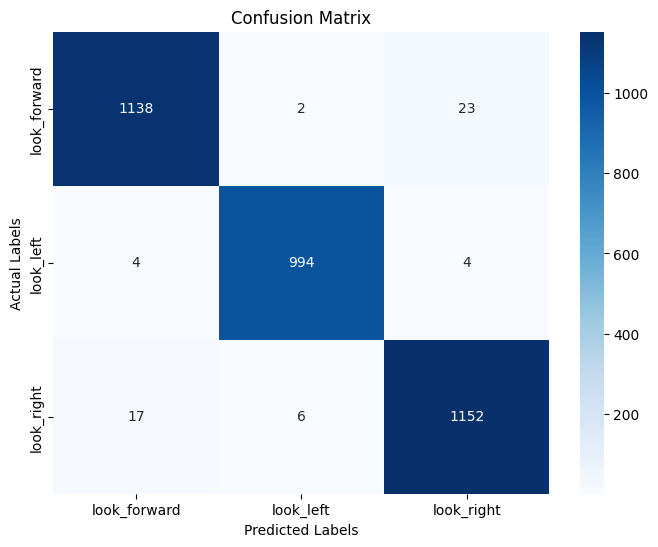

Classification Report:
               precision    recall  f1-score   support

look_forward       0.98      0.98      0.98      1163
   look_left       0.99      0.99      0.99      1002
  look_right       0.98      0.98      0.98      1175

    accuracy                           0.98      3340
   macro avg       0.98      0.98      0.98      3340
weighted avg       0.98      0.98      0.98      3340



In [56]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(history_modelB_1.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

## 3. ModelC - ModelA with maxbooling and batch normaliztion layers

In [29]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# First convolutional block
conv1 = Conv2D(16, 3, activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
max_pool1 = MaxPooling2D(3)(batch_norm1)

conv2 = Conv2D(32, 3, activation='relu')(max_pool1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling2D(3)(batch_norm2)

# Flatten layer
flatten = Flatten()(max_pool2)

# Fully connected layers
dense1 = Dense(32, activation='relu')(flatten)
batch_norm3 = BatchNormalization()(dense1)
output_layer = Dense(3, activation='softmax')(batch_norm3)

# Create base model
modelC = Model(inputs=input_layer, outputs=output_layer)

In [30]:
modelC.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 18, 18, 32)        128   

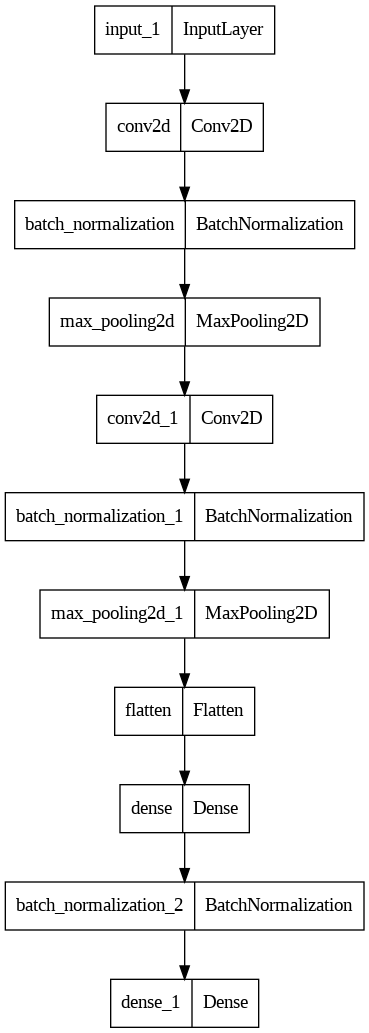

In [31]:
plot_model(modelC)

In [32]:
# Compiling the model
modelC.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Define the path to save the model
model_checkpoint_path_modelC = os.path.join(path, 'bestModel_modelC.h5')

In [36]:
callback_modelC = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelC,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [37]:
# Train the model
history_modelC_1 = modelC.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_modelC)

Epoch 1/30
169/170 [============================>.] - ETA: 0s - loss: 0.3836 - accuracy: 0.8504
Epoch 1: val_loss improved from inf to 0.94275, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC.h5
170/170 [==============================] - 7s 34ms/step - loss: 0.3836 - accuracy: 0.8505 - val_loss: 0.9427 - val_accuracy: 0.5343
Epoch 2/30
  3/170 [..............................] - ETA: 4s - loss: 0.1738 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/170 [============================>.] - ETA: 0s - loss: 0.2057 - accuracy: 0.9336
Epoch 2: val_loss improved from 0.94275 to 0.64808, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC.h5
170/170 [==============================] - 5s 29ms/step - loss: 0.2052 - accuracy: 0.9338 - val_loss: 0.6481 - val_accuracy: 0.6927
Epoch 3/30
168/170 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9488
Epoch 3: val_loss improved from 0.64808 to 0.32538, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC.h5
170/170 [==============================] - 5s 30ms/step - loss: 0.1535 - accuracy: 0.9489 - val_loss: 0.3254 - val_accuracy: 0.8976
Epoch 4/30
169/170 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9615
Epoch 4: val_loss improved from 0.32538 to 0.15703, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC.h5
170/170 [

In [38]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelC_1 = history_modelC_1.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelC_1[0])
print('Test accuracy:', test_loss_accuracy_modelC_1[1])

105/105 [==============================] - 1s 8ms/step - loss: 0.0742 - accuracy: 0.9829
Test loss: 0.07418666779994965
Test accuracy: 0.9829341173171997


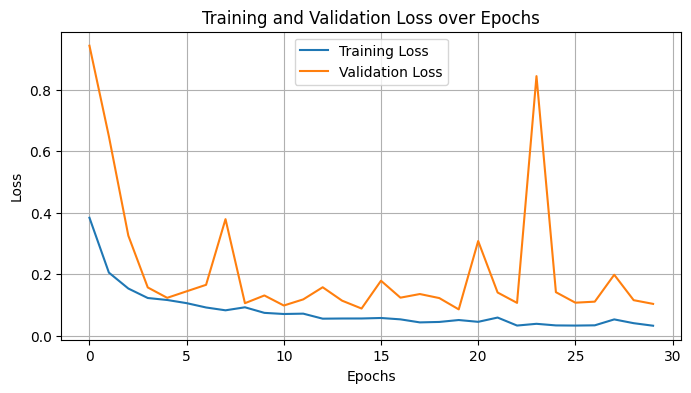

In [40]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelC_1.history['loss'], label='Training Loss')
plt.plot(history_modelC_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

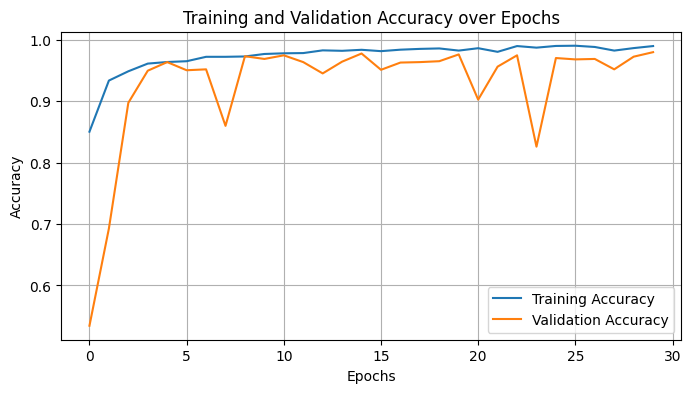

In [41]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelC_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelC_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [39]:
# Save the entire model
history_modelC_1.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelC_1.h5')

105/105 [==============================] - 1s 8ms/step


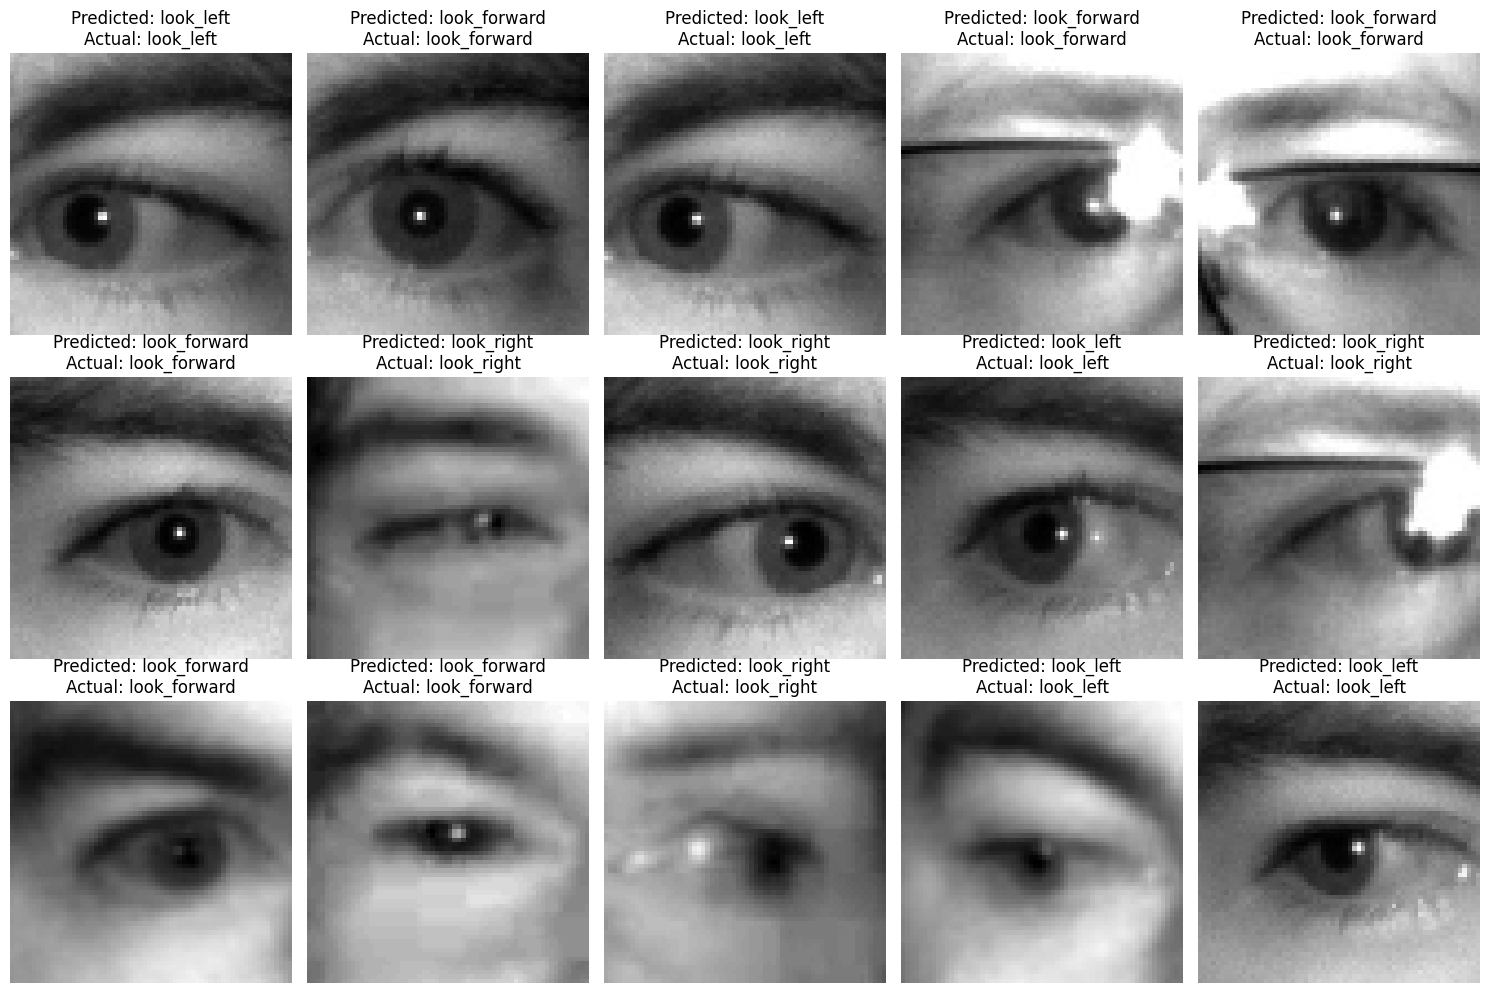

In [42]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelC_1.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 8ms/step


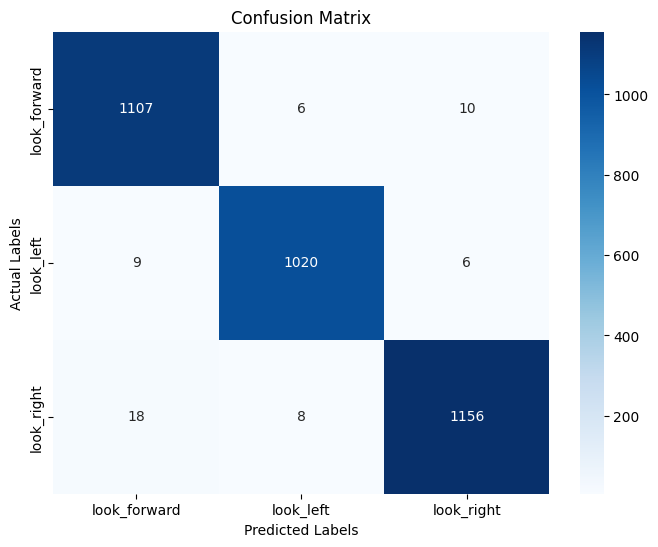

Classification Report:
               precision    recall  f1-score   support

look_forward       0.98      0.99      0.98      1123
   look_left       0.99      0.99      0.99      1035
  look_right       0.99      0.98      0.98      1182

    accuracy                           0.98      3340
   macro avg       0.98      0.98      0.98      3340
weighted avg       0.98      0.98      0.98      3340



In [43]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(history_modelC_1.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

## 4. ModelD - Model with conv2D(16,32, 64) + Flatten + Dense(32,3)

In [70]:
# Define input layer
input_layer = Input(shape=(64, 64, 1))

# First convolutional block
conv1 = Conv2D(16, 3, activation='relu')(input_layer)
batch_norm1 = BatchNormalization()(conv1)
max_pool1 = MaxPooling2D(3)(batch_norm1)

conv2 = Conv2D(32, 3, activation='relu')(max_pool1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling2D(3)(batch_norm2)

conv3 = Conv2D(64, 3, activation='relu')(max_pool2)
batch_norm3 = BatchNormalization()(conv3)
max_pool3 = MaxPooling2D(3)(batch_norm3)

# Flatten layer
flatten = Flatten()(max_pool3)

# Fully connected layers
dense1 = Dense(32, activation='relu')(flatten)
batch_norm4 = BatchNormalization()(dense1)
output_layer = Dense(3, activation='softmax')(batch_norm4)

# Create base model
modelD = Model(inputs=input_layer, outputs=output_layer)

In [71]:
modelD.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 16)        160       
                                                                 
 batch_normalization_3 (Bat  (None, 62, 62, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 32)        4640      
                                                                 
 batch_normalization_4 (Bat  (None, 18, 18, 32)        128 

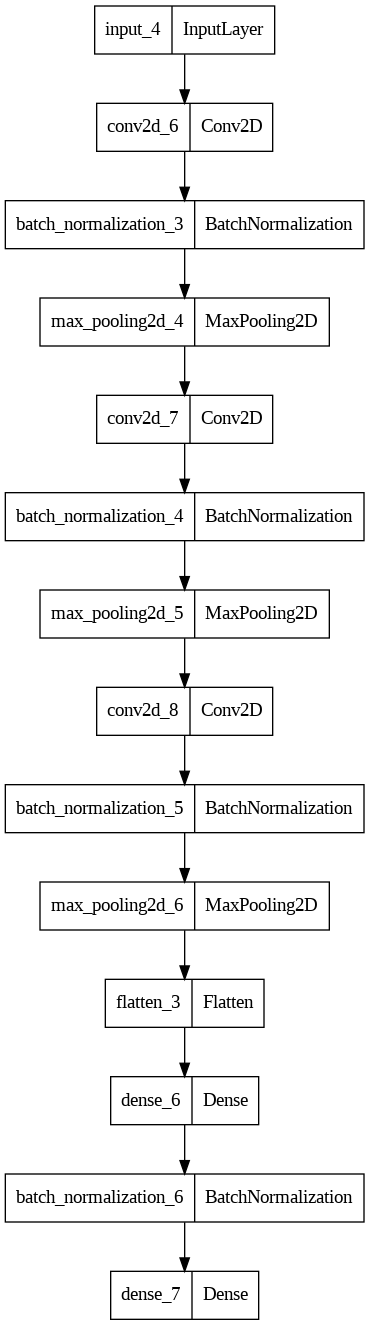

In [72]:
plot_model(modelD)

In [73]:
# Compiling the model
modelD.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [74]:
# Define the path to save the model
model_checkpoint_path_modelD = os.path.join(path, 'bestModel_modelD.h5')

In [75]:
callback_modelD = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelD,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [76]:
# Train the model
history_modelD_1 = modelD.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback_modelD)

Epoch 1/30
169/170 [============================>.] - ETA: 0s - loss: 0.4218 - accuracy: 0.8480
Epoch 1: val_loss improved from inf to 1.66167, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelD.h5
170/170 [==============================] - 8s 33ms/step - loss: 0.4214 - accuracy: 0.8483 - val_loss: 1.6617 - val_accuracy: 0.3427
Epoch 2/30
  3/170 [..............................] - ETA: 4s - loss: 0.1326 - accuracy: 0.9792

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/170 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9351
Epoch 2: val_loss improved from 1.66167 to 1.45222, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelD.h5
170/170 [==============================] - 5s 30ms/step - loss: 0.2002 - accuracy: 0.9349 - val_loss: 1.4522 - val_accuracy: 0.4105
Epoch 3/30
169/170 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9528
Epoch 3: val_loss improved from 1.45222 to 0.22192, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelD.h5
170/170 [==============================] - 5s 30ms/step - loss: 0.1581 - accuracy: 0.9528 - val_loss: 0.2219 - val_accuracy: 0.9263
Epoch 4/30
169/170 [============================>.] - ETA: 0s - loss: 0.1257 - accuracy: 0.9615
Epoch 4: val_loss improved from 0.22192 to 0.10822, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelD.h5
170/170 [

In [77]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelD_1 = history_modelD_1.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelD_1[0])
print('Test accuracy:', test_loss_accuracy_modelD_1[1])

105/105 [==============================] - 1s 9ms/step - loss: 0.5453 - accuracy: 0.8680
Test loss: 0.5452633500099182
Test accuracy: 0.8679640889167786


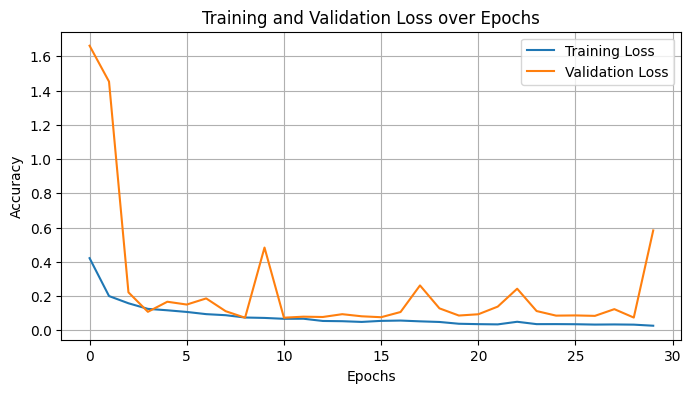

In [81]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelD_1.history['loss'], label='Training Loss')
plt.plot(history_modelD_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


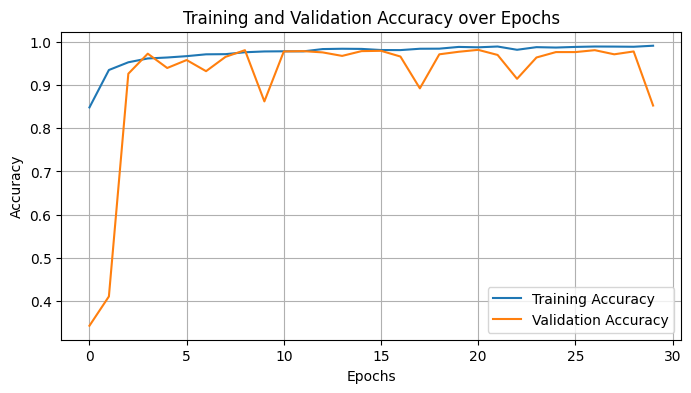

In [79]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelD_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelD_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [98]:
# Save the entire model
history_modelD_1.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelD_1.h5')

105/105 [==============================] - 1s 9ms/step


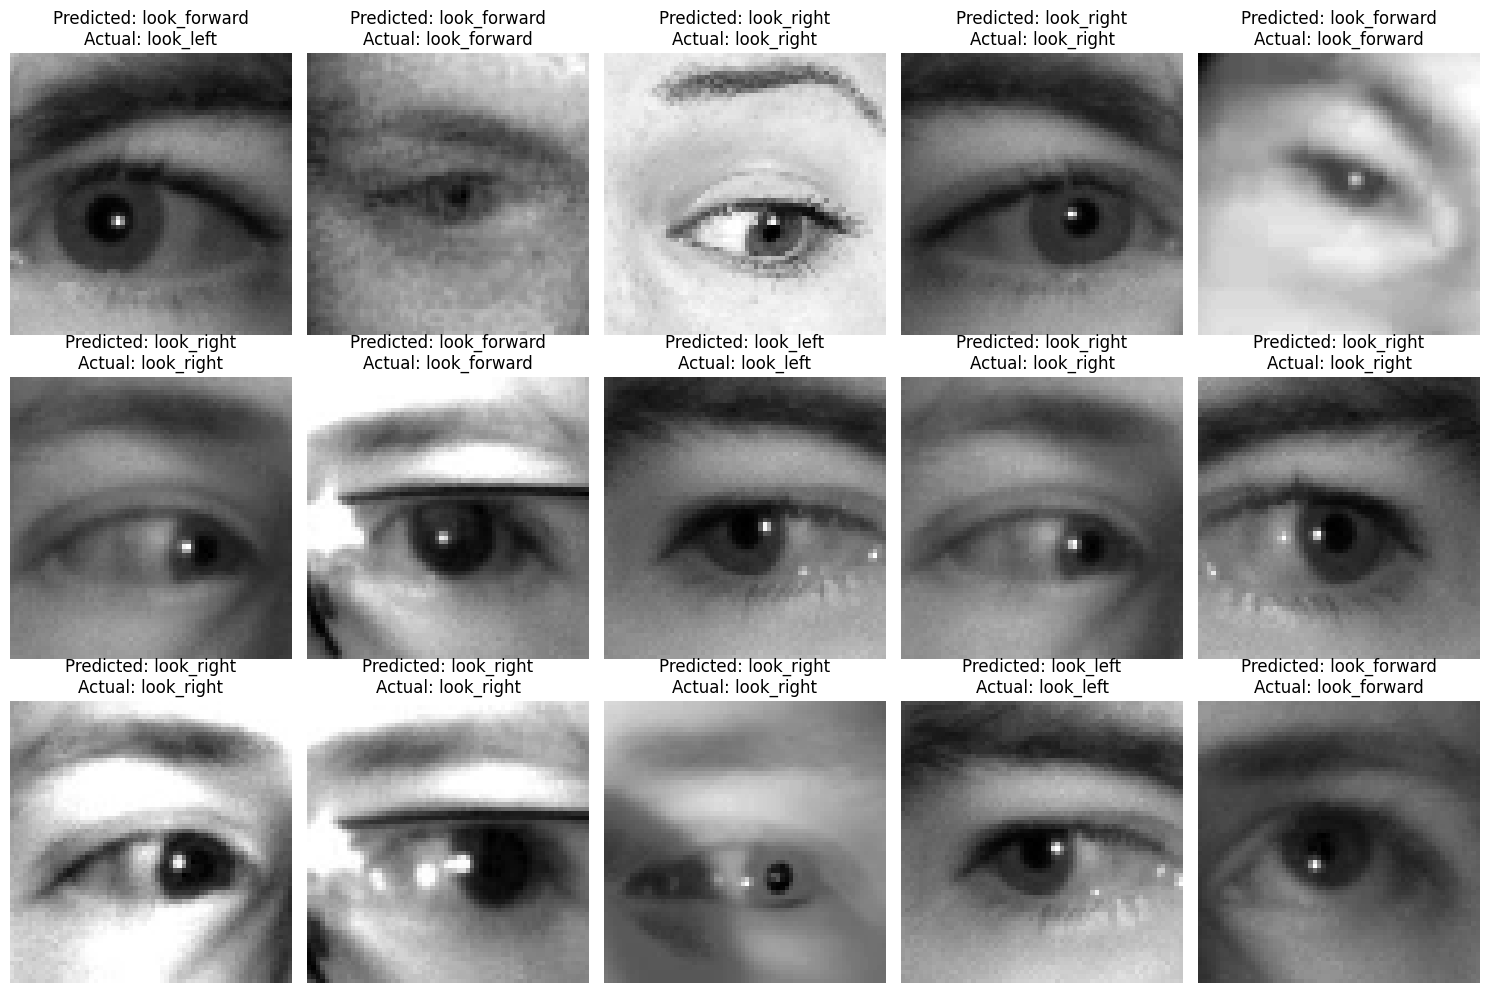

In [82]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelD_1.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 9ms/step


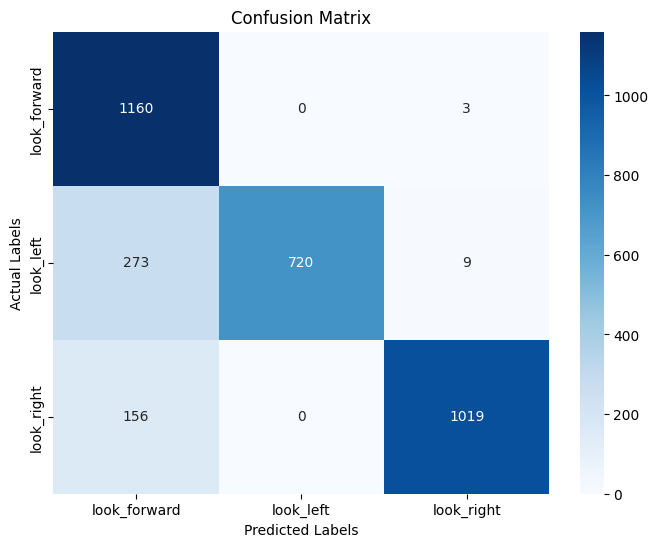

Classification Report:
               precision    recall  f1-score   support

look_forward       0.73      1.00      0.84      1163
   look_left       1.00      0.72      0.84      1002
  look_right       0.99      0.87      0.92      1175

    accuracy                           0.87      3340
   macro avg       0.91      0.86      0.87      3340
weighted avg       0.90      0.87      0.87      3340



In [83]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(history_modelD_1.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

## 5. ModelE - ModelC with 64 batch size

In [84]:
# Define the path to save the model
model_checkpoint_path_modelE = os.path.join(path, 'bestModel_modelE.h5')

In [90]:
callback_modelEE = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelE,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [91]:
# Train the model
history_modelE_1 = modelC.fit(x_train, y_train_onehot, validation_split=0.2, epochs=30, batch_size=64, callbacks=callback_modelEE)

Epoch 1/30
84/85 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8702
Epoch 1: val_loss improved from inf to 1.23294, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelE.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 7s 63ms/step - loss: 0.3501 - accuracy: 0.8709 - val_loss: 1.2329 - val_accuracy: 0.3427
Epoch 2/30
84/85 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9466
Epoch 2: val_loss did not improve from 1.23294
85/85 [==============================] - 4s 50ms/step - loss: 0.1765 - accuracy: 0.9460 - val_loss: 1.6314 - val_accuracy: 0.3427
Epoch 3/30
84/85 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9611
Epoch 3: val_loss did not improve from 1.23294
85/85 [==============================] - 4s 49ms/step - loss: 0.1390 - accuracy: 0.9607 - val_loss: 1.9104 - val_accuracy: 0.3427
Epoch 4/30
84/85 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9688
Epoch 4: val_loss did not improve from 1.23294
85/85 [==============================] - 4s 53ms/step - loss: 0.1063 - accuracy: 0.9690 - val_loss: 1.4291 - val_accuracy: 0.5446
Epoch 5/30
84/85 [============================>.] - ETA: 

In [93]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelE_1 = history_modelE_1.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelE_1[0])
print('Test accuracy:', test_loss_accuracy_modelE_1[1])

105/105 [==============================] - 1s 9ms/step - loss: 0.0709 - accuracy: 0.9805
Test loss: 0.07092542201280594
Test accuracy: 0.9805389046669006


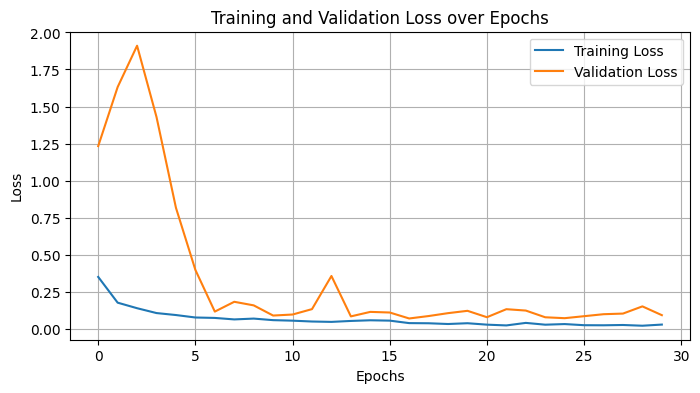

In [94]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelE_1.history['loss'], label='Training Loss')
plt.plot(history_modelE_1.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

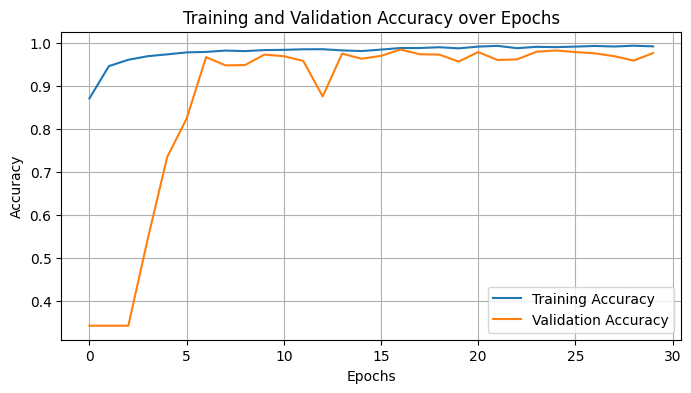

In [95]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelE_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelE_1.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [100]:
# Save the entire model
history_modelE_1.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelE_1.h5')

105/105 [==============================] - 1s 10ms/step


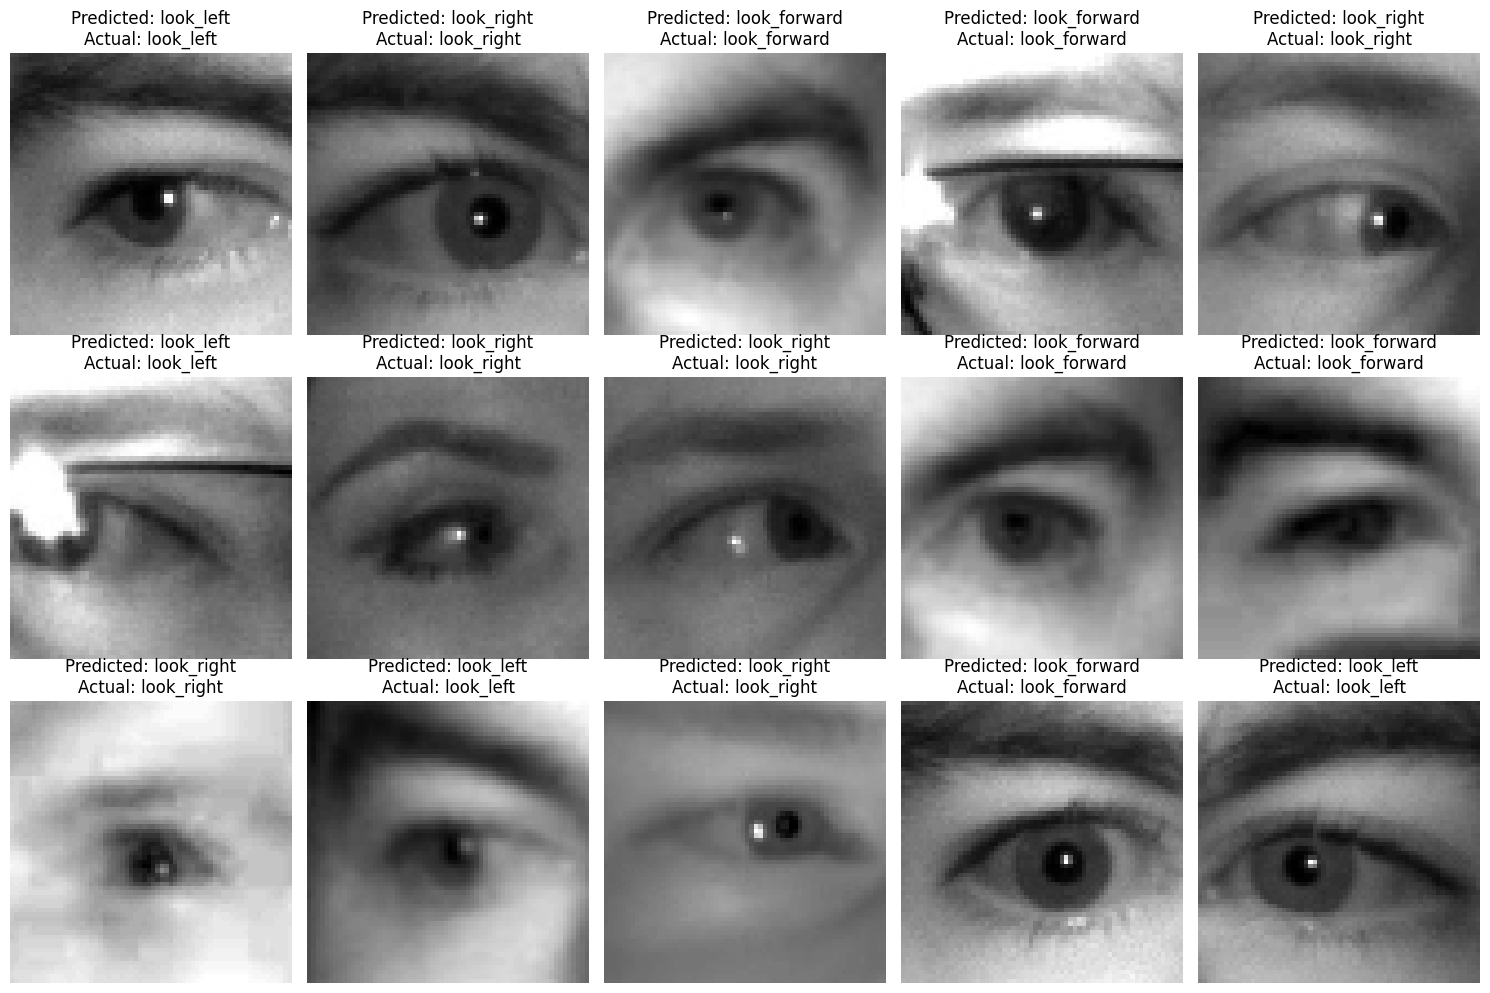

In [101]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelE_1.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 9ms/step


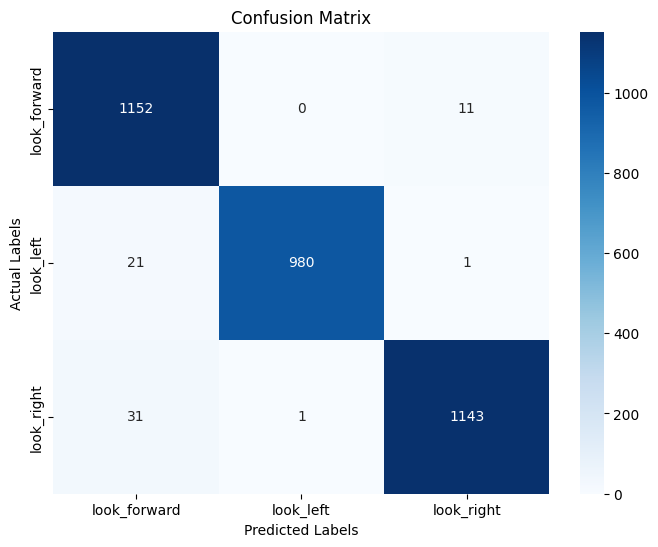

In [103]:
# Predict labels for test images
predicted_labels = np.argmax(history_modelE_1.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()



In [104]:
# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

look_forward       0.96      0.99      0.97      1163
   look_left       1.00      0.98      0.99      1002
  look_right       0.99      0.97      0.98      1175

    accuracy                           0.98      3340
   macro avg       0.98      0.98      0.98      3340
weighted avg       0.98      0.98      0.98      3340



## 6. ModelA with data augmentation

In [123]:
# Define the path to save the model
model_checkpoint_path_modelA_a = os.path.join(path, 'bestModel_modelA_a.h5')

In [127]:
callback_modelA_aaa = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelA_a,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [112]:
# Split the training data into training and validation sets
x_train_1, x_val, y_train_encoded_1, y_val_encoded = train_test_split(x_train, y_train_onehot, test_size=0.2, random_state=42)

In [128]:
# Train the model
history_modelA_2 = modelA.fit(
    train_generator.flow(x_train_1, y_train_encoded_1, batch_size=32),
    steps_per_epoch=len(x_train_1) / 32,
    epochs=30,
    validation_data=(x_val, y_val_encoded),
    callbacks=callback_modelA_aaa
)

Epoch 1/30
170/169 [==============================] - ETA: 0s - loss: 1.1404 - accuracy: 0.3936
Epoch 1: val_loss improved from inf to 1.07872, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA_a.h5
169/169 [==============================] - 13s 72ms/step - loss: 1.1404 - accuracy: 0.3936 - val_loss: 1.0787 - val_accuracy: 0.3662


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
170/169 [==============================] - ETA: 0s - loss: 1.0510 - accuracy: 0.4430
Epoch 2: val_loss improved from 1.07872 to 1.00429, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA_a.h5
169/169 [==============================] - 13s 75ms/step - loss: 1.0510 - accuracy: 0.4430 - val_loss: 1.0043 - val_accuracy: 0.4878
Epoch 3/30
170/169 [==============================] - ETA: 0s - loss: 1.0083 - accuracy: 0.4781
Epoch 3: val_loss improved from 1.00429 to 0.94253, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelA_a.h5
169/169 [==============================] - 12s 73ms/step - loss: 1.0083 - accuracy: 0.4781 - val_loss: 0.9425 - val_accuracy: 0.5085
Epoch 4/30
170/169 [==============================] - ETA: 0s - loss: 0.9837 - accuracy: 0.4830
Epoch 4: val_loss did not improve from 0.94253
169/169 [==============================] - 12s 70ms/step - loss: 0.9837 - accuracy: 0.4830 - va

In [129]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelA_1a = history_modelA_2.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelA_1a[0])
print('Test accuracy:', test_loss_accuracy_modelA_1a[1])

105/105 [==============================] - 1s 13ms/step - loss: 0.6619 - accuracy: 0.6659
Test loss: 0.6619374752044678
Test accuracy: 0.6658682823181152


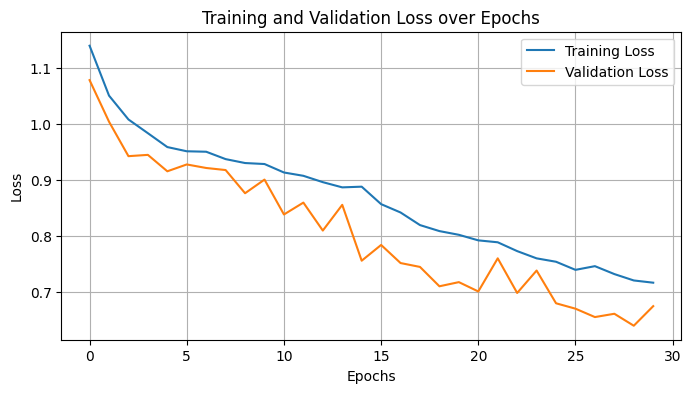

In [130]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelA_2.history['loss'], label='Training Loss')
plt.plot(history_modelA_2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

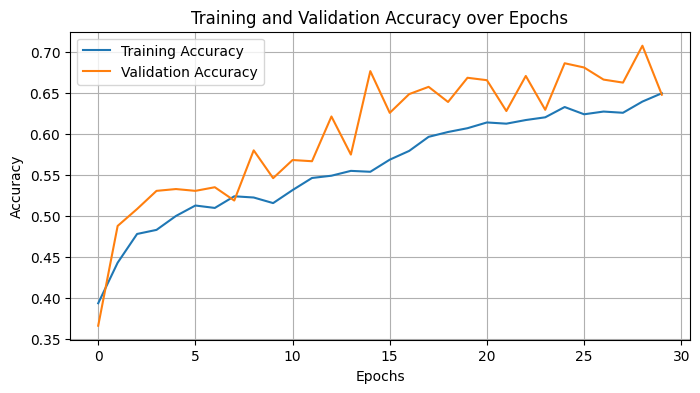

In [131]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelA_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelA_2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [132]:
# Save the entire model
history_modelA_2.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelA_2.h5')

105/105 [==============================] - 1s 13ms/step


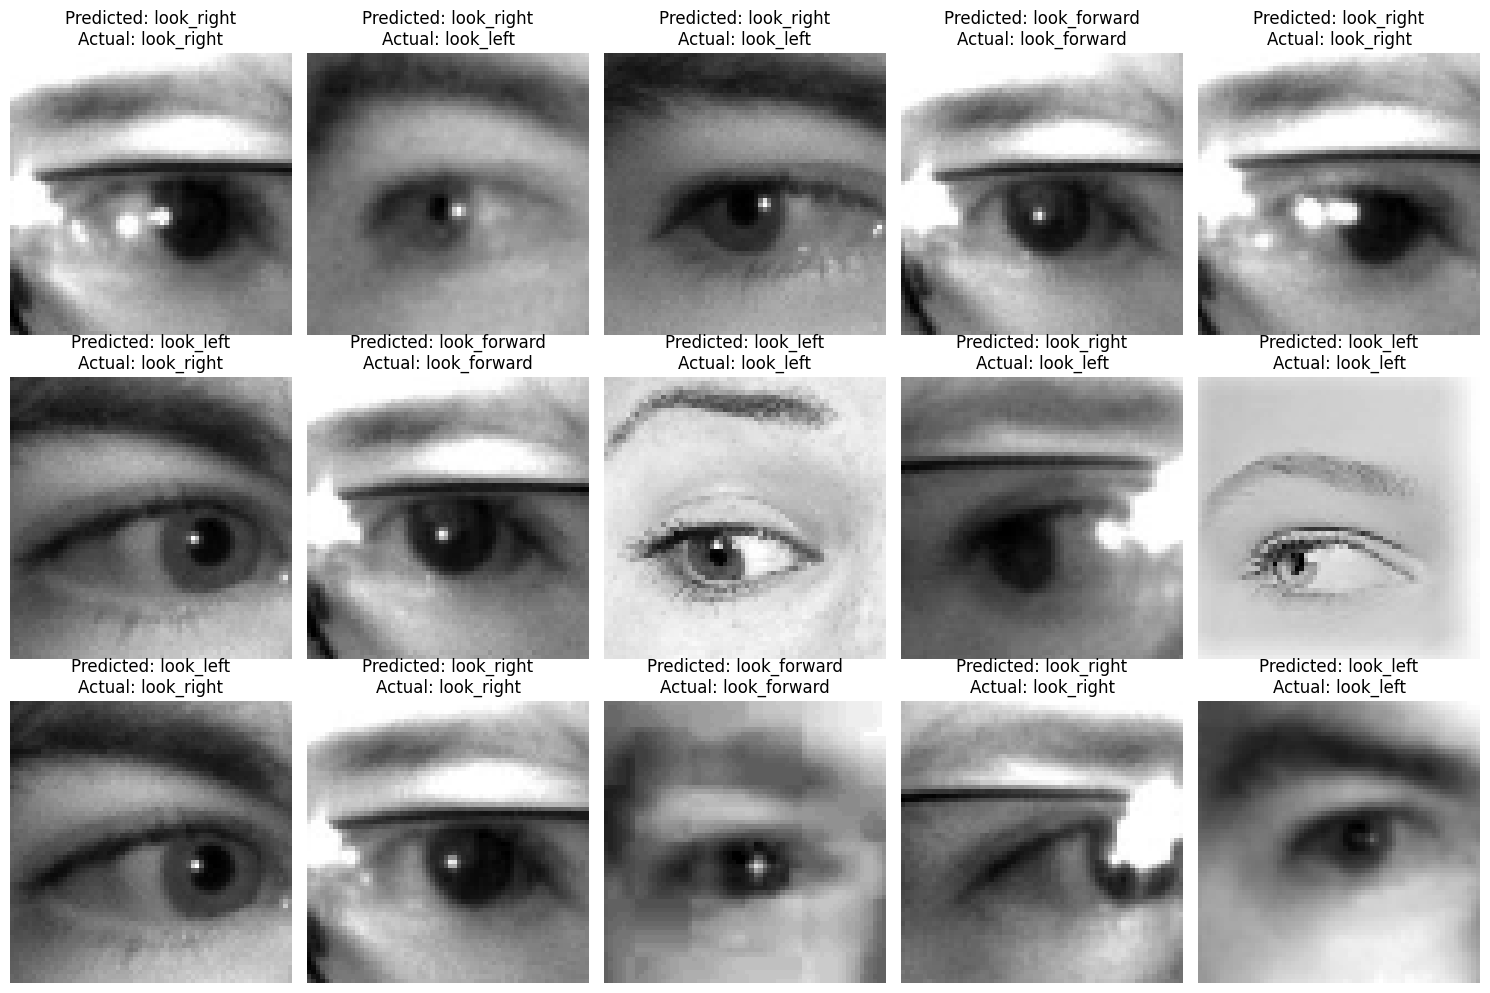

In [133]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelA_2.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


105/105 [==============================] - 1s 12ms/step


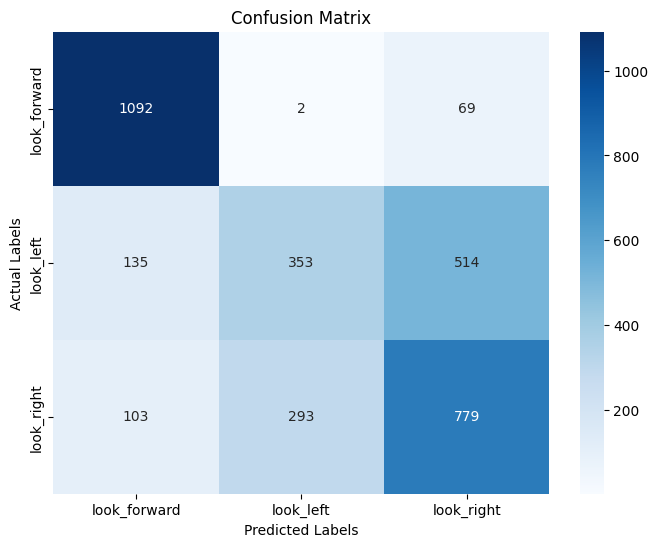

Classification Report:
               precision    recall  f1-score   support

look_forward       0.82      0.94      0.88      1163
   look_left       0.54      0.35      0.43      1002
  look_right       0.57      0.66      0.61      1175

    accuracy                           0.67      3340
   macro avg       0.65      0.65      0.64      3340
weighted avg       0.65      0.67      0.65      3340



In [134]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict labels for test images
predicted_labels = np.argmax(history_modelA_2.model.predict(x_test), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_original = np.argmax(y_test_onehot, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_original, predicted_labels)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_original, predicted_labels, target_names=label_mapping.values())
print("Classification Report:\n", class_report)

## 7. ModelC with data augmentation

In [135]:
# Define the path to save the model
model_checkpoint_path_modelC_a = os.path.join(path, 'bestModel_modelC_a.h5')

In [143]:
callback_modelC_1 = tf.keras.callbacks.ModelCheckpoint(
    # Define path to save best model
    filepath=model_checkpoint_path_modelC_a,
    # Save full model
    save_weights_only=False,
    # Monitor validation loss for select best model
    monitor='val_loss',
    # Define the minimum mode
    mode='min',
    # Save the best model
    save_best_only=True,
    verbose =1)

In [144]:
# Train the model
history_modelC_2 = modelC.fit(
    train_generator.flow(x_train_1, y_train_encoded_1, batch_size=32),
    steps_per_epoch=len(x_train_1) / 32,
    epochs=30,
    validation_data=(x_val, y_val_encoded),
    callbacks=callback_modelC_1
)

Epoch 1/30
170/169 [==============================] - ETA: 0s - loss: 1.0728 - accuracy: 0.4681
Epoch 1: val_loss improved from inf to 1.06890, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC_a.h5
169/169 [==============================] - 7s 35ms/step - loss: 1.0728 - accuracy: 0.4681 - val_loss: 1.0689 - val_accuracy: 0.3965


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
170/169 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.5142
Epoch 2: val_loss did not improve from 1.06890
169/169 [==============================] - 6s 32ms/step - loss: 0.9725 - accuracy: 0.5142 - val_loss: 1.1073 - val_accuracy: 0.4473
Epoch 3/30
170/169 [==============================] - ETA: 0s - loss: 0.9099 - accuracy: 0.5548
Epoch 3: val_loss improved from 1.06890 to 0.90396, saving model to ../content/drive/MyDrive/Research/Saved_models/Gaze_detection/bestModel_modelC_a.h5
169/169 [==============================] - 6s 33ms/step - loss: 0.9099 - accuracy: 0.5548 - val_loss: 0.9040 - val_accuracy: 0.5247
Epoch 4/30
170/169 [==============================] - ETA: 0s - loss: 0.8678 - accuracy: 0.5774
Epoch 4: val_loss did not improve from 0.90396
169/169 [==============================] - 5s 31ms/step - loss: 0.8678 - accuracy: 0.5774 - val_loss: 0.9059 - val_accuracy: 0.5136
Epoch 5/30
169/169 [============================>.] - ETA: 0s - loss: 

In [145]:
# Model evaluation

# Extract test loss and accuracy
test_loss_accuracy_modelC_1a = history_modelC_2.model.evaluate(x_test, y_test_onehot, verbose=1)

# Print accuracy
print('Test loss:', test_loss_accuracy_modelC_1a[0])
print('Test accuracy:', test_loss_accuracy_modelC_1a[1])

105/105 [==============================] - 1s 9ms/step - loss: 0.5351 - accuracy: 0.7237
Test loss: 0.5351068377494812
Test accuracy: 0.723652720451355


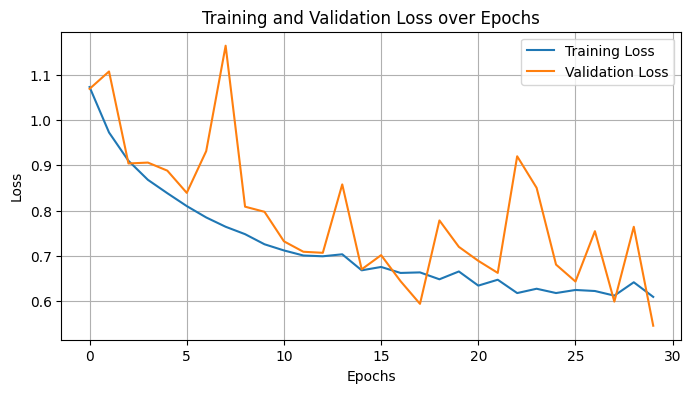

In [149]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 4))

# Plot the loss
plt.plot(history_modelC_2.history['loss'], label='Training Loss')
plt.plot(history_modelC_2.history['val_loss'], label='Validation Loss')
# Plot labels for axis and titles
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Add legend
plt.legend()
plt.grid(True)

# Plot the graph
plt.show()

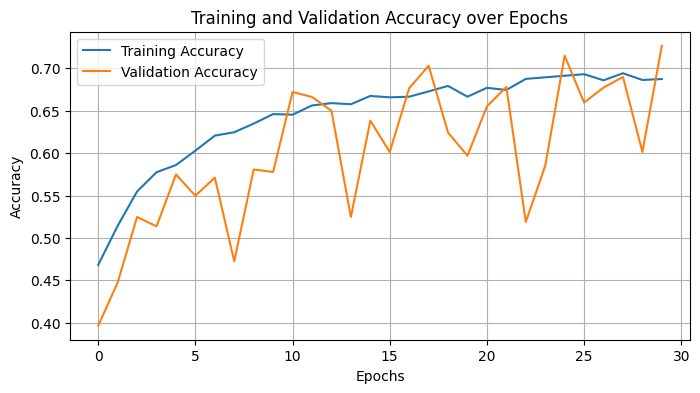

In [150]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 4))

# Plot the accuracy
plt.plot(history_modelC_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_modelC_2.history['val_accuracy'], label='Validation Accuracy')
# Plot labels for axis and titles
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Add legend
plt.legend()
plt.grid(True)
# Plot the graph
plt.show()


In [151]:
# Save the entire model
history_modelC_2.model.save('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelC_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


105/105 [==============================] - 1s 8ms/step


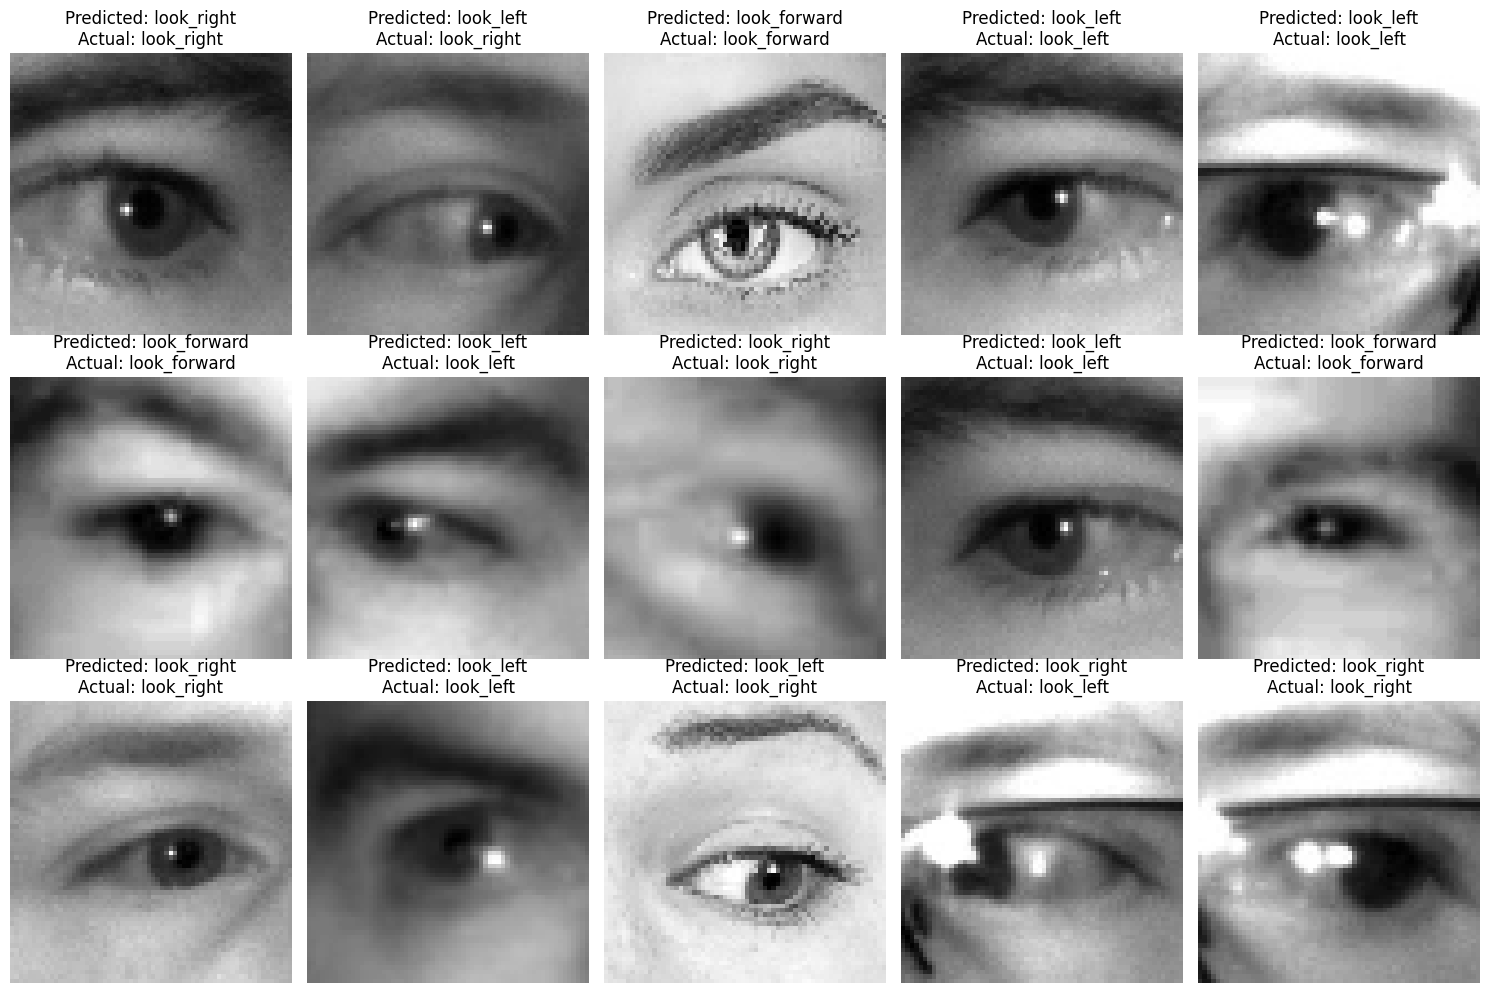

In [152]:
# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(history_modelC_2.model.predict(x_test), axis=1)

# Randomly select 15 indices
random_indices = np.random.choice(len(x_test), size=15, replace=False)

# Create a subplot for visualization
plt.figure(figsize=(15, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[index].reshape(64, 64), cmap='gray')
    predicted_label = label_mapping[predicted_labels[index]]
    actual_label = label_mapping[np.argmax(y_test_onehot[index])]
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Test

In [25]:
# Load image
me_img = '../content/drive/MyDrive/Research/test/11.jpg'
me_img = cv2.imread(me_img)

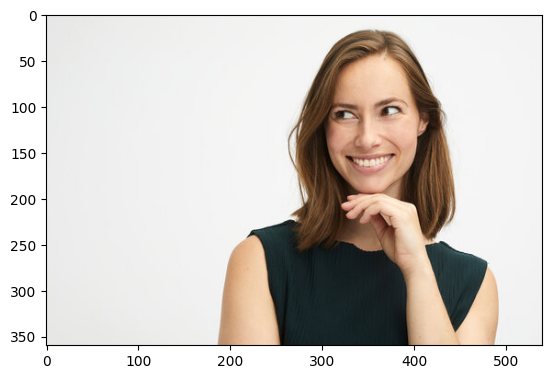

In [26]:
# Display image
plt.imshow(cv2.cvtColor(me_img,cv2.COLOR_BGR2RGB))

In [27]:
# Load the Haar cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('../content/drive/MyDrive/Research/haarcascade_data/haarcascade_frontalface_default.xml')

In [28]:
# Load the Haar cascade classifier for eyes detection
eye_cascade = cv2.CascadeClassifier('../content/drive/MyDrive/Research/haarcascade_data/haarcascade_eye.xml')

In [29]:
# Detect eyes in the image using the eye cascade classifier
eyes = eye_cascade.detectMultiScale(me_img, scaleFactor=1.1, minNeighbors=4)

In [30]:
# Iterate over the list of rectangles
for x,y,w,h in eyes:
    # Draw squares over detected eyes
    cv2.rectangle(me_img,(x,y),(x+w ,y+h), (0, 255, 0), 2)

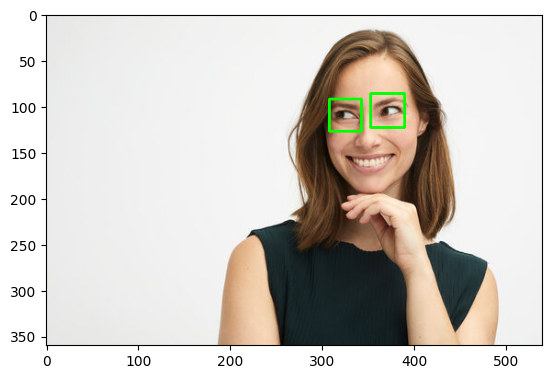

In [31]:
# Display image with detected rectangels
plt.imshow(cv2.cvtColor(me_img, cv2.COLOR_BGR2RGB))

In [32]:
# Iterate over the detected eye regions
for x,y,w,h in eyes:
     # Extract the region of interest from grayscale and color images
    roi_gray = me_img[y:y+h, x:x+w]
    roi_color = me_img[y:y+h, x:x+w]

    # Detect eyes within the ROI
    eyess = eye_cascade.detectMultiScale(roi_gray)

    # Check if eyes are detected
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for(ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey: ey+eh, ex:ex+ew]

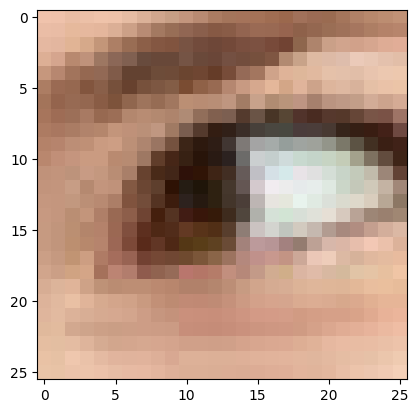

In [33]:
# Show detected eye
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [34]:
# Check the detected eye image shape
eyes_roi.shape

(26, 26, 3)

In [35]:
# Resize it into 64x64
final_image = cv2.resize(eyes_roi,(64,64))

In [36]:
# Confirm the image size
final_image.shape

(64, 64, 3)

In [37]:
# Convert the image into grayscale
grayscale_img = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

In [38]:
best_model_v2 = load_model('../content/drive/MyDrive/Research/Saved_models/Gaze_detection/modelC_1.h5')

In [42]:
# Define the image as an array
img_array = img_to_array(grayscale_img)

# Expand dimensions to create batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Normalize pixel values to [0, 1]
img_array /= 255.

# Mapping dictionary for integer labels to categories
label_mapping = {0: 'look_forward', 1: 'look_left', 2: 'look_right'}

# Predict labels for test images
predicted_labels = np.argmax(best_model_v2.predict(img_array), axis=1)

1/1 [==============================] - 0s 277ms/step


In [43]:
print(predicted_labels)

[1]


In [45]:
# Predict labels for test images
predicted_labels = np.argmax(best_model_v2.predict(img_array), axis=1)

# Map integer labels to categories
predicted_categories = [label_mapping[label] for label in predicted_labels]

print(predicted_categories)

1/1 [==============================] - 0s 22ms/step
['look_left']
